В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [53]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import confusion_matrix, roc_auc_score, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
import joblib

warnings.filterwarnings('ignore')

In [54]:
train_raw_df = pd.read_csv('train.csv')
test_raw_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Area under ROC score on Train dataset: 0.88391


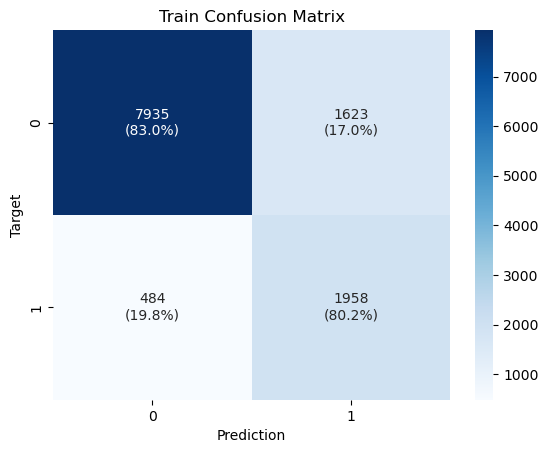

Area under ROC score on Validation dataset: 0.88011


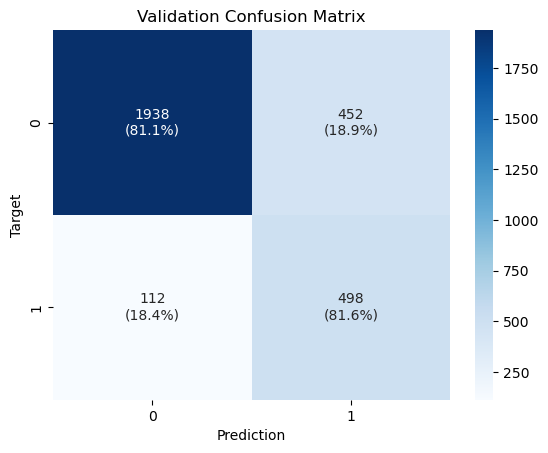

In [55]:
train_df, val_df = train_test_split(
    train_raw_df,
    test_size=0.2,
    random_state=42,
    stratify=train_raw_df['Exited'],
)

# Створюємо трен. і вал. набори
target_col = 'Exited'
drop_cols = ['id', 'CustomerId', 'Surname']
input_cols = [col for col in train_df.columns if col not in drop_cols + [target_col]]
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()


# Виявляємо числові і категоріальні колонки
# numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()   # якщо будемо трансформувати всі числові ознаки
binary_cols = ['HasCrCard','IsActiveMember']
numeric_cols = [col for col in train_inputs.select_dtypes(include=['number']).columns.tolist() if col not in binary_cols]
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols),
    ('bin', 'passthrough', binary_cols),
])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', penalty='l2',C=0.05, solver='liblinear', max_iter=5000)),
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    proba = model_pipeline.predict_proba(inputs)[:, 1]
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, proba)
    print(f'Area under ROC score on {name} dataset: {roc_auc:.5f}')

    cm = confusion_matrix(targets, preds)
    plt.figure()
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    labels = np.array([[f'{cm[i, j]}\n({cm_norm[i, j]:.1%})' for j in range(cm.shape[1])]
    for i in range(cm.shape[0])])
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg_pipeline.joblib');

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train (poly2) dataset: 0.92203


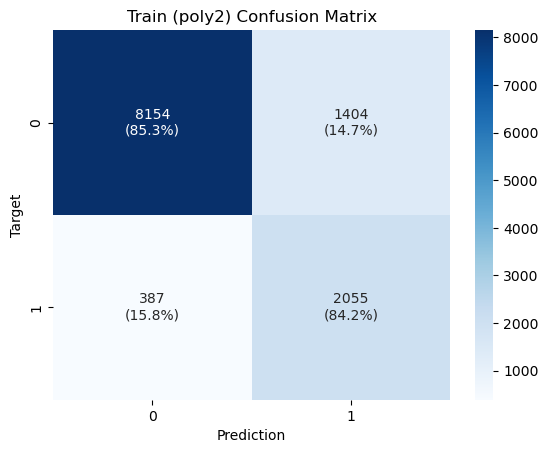

Area under ROC score on Validation (poly2) dataset: 0.91876


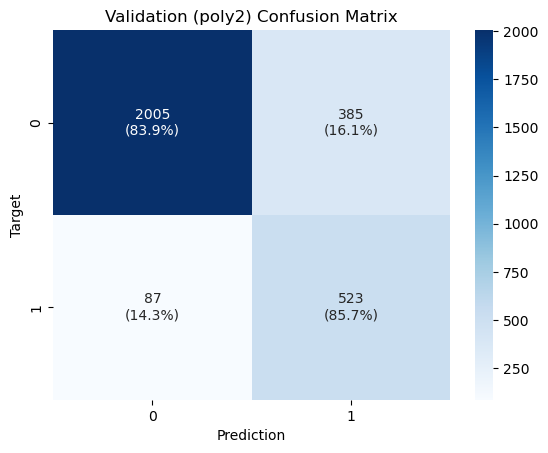

In [56]:
numeric_transformer_poly2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
])

preprocessor_poly2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols),
    ]
)

model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly2),
    ('classifier', LogisticRegression(class_weight='balanced', penalty='l2',C=0.05, solver='liblinear', max_iter=5000)),
])

model_pipeline_poly2.fit(train_inputs, train_targets)

train_preds_poly2 = predict_and_plot(model_pipeline_poly2, train_inputs, train_targets, 'Train (poly2)')
val_preds_poly2 = predict_and_plot(model_pipeline_poly2, val_inputs, val_targets, 'Validation (poly2)')

Отже, бачимо наступні результати: 
- Train AUROC = 0.92203
- Val AUROC = 0.91876

Різниця в ~ 0.0033 — це дуже маленький розрив, тобто:
- сильного overfit немає
- underfit теж не бачимо, адже метрика висока і на train, і на val
- генералізація добра: модель майже однаково працює на train і val

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train (poly4) dataset: 0.93161


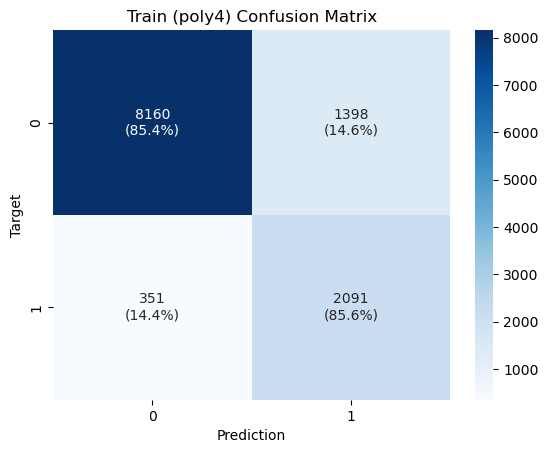

Area under ROC score on Validation (poly4) dataset: 0.92836


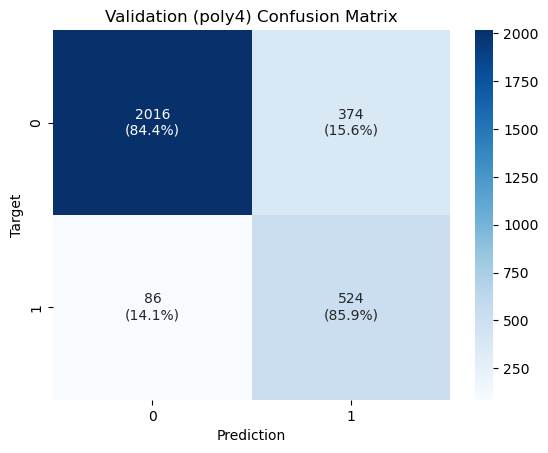

In [57]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler()),
])

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols),
    ]
)

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(class_weight='balanced', penalty='l2',C=0.05, solver='liblinear', max_iter=5000)),
])

model_pipeline_poly4.fit(train_inputs, train_targets)

train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train (poly4)')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation (poly4)')

Модель з поліноміальними ознаками степеня 4 демонструє невелике покращення AUROC порівняно зі степенем 2 (Val AUROC ≈ 0.91876 для degree = 2 та Val AUROC ≈ 0.92836 для degree = 4, тобто приріст ≈ +0.01). Різниця між train та validation невелика, що свідчить про хорошу генералізацію. Ознак явного overfitting не спостерігається. Модель показує високу здатність розрізняти класи.

***Сформуємо submission для змагання:***

In [58]:
X_test = test_raw_df[input_cols].copy()
test_proba = model_pipeline_poly4.predict_proba(X_test)[:, 1]

pred_series = pd.Series(test_proba, index=test_raw_df["id"])
submission = sample_submission.copy()
submission["Exited"] = submission["id"].map(pred_series)

submission.to_csv("submission_poly4.csv", index=False)
submission.head()

,id,Exited
0,15000,0.191618
1,15001,0.074936
2,15002,0.178300
3,15003,0.760092
4,15004,0.109405


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [59]:
reg_df = pd.read_csv('regression_data.csv')

In [60]:
reg_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [61]:
X = reg_df.drop(columns=['target'])
y = reg_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

reg_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])

reg_pipeline.fit(X_train, y_train)

train_pred = reg_pipeline.predict(X_train)
test_pred = reg_pipeline.predict(X_test)

train_rmse_poly5 = root_mean_squared_error(y_train, train_pred)
test_rmse_poly5 = root_mean_squared_error(y_test, test_pred)
train_r2_poly5 = r2_score(y_train, train_pred)
test_r2_poly5 = r2_score(y_test, test_pred)

print(f'Train RMSE: {train_rmse_poly5:.4f}, R2: {train_r2_poly5:.4f}')
print(f'Test RMSE: {test_rmse_poly5:.4f}, R2: {test_r2_poly5:.4f}')

Train RMSE: 0.0000, R2: 1.0000
Test RMSE: 12.6767, R2: 0.9311


In [62]:
reg_pipeline.named_steps['poly'].n_output_features_

251

In [63]:
reg_df.shape

(129, 6)

- На тренувальних даних бачимо, показники R² = 1.0 та RMSE = 0, з чого можна зробити висновок, що модель ідеально підлаштувалась під тренувальні дані, що є ознакою overfitting. 

- На тестових даних бачимо, що R² = 0.9311 та RMSE = 12.68, що показує, що модель зберігає достатньо високу якість, однак різниця між train і test метриками вказує на нестійкість моделі.

- Але візьмемо до уваги, що даних маємо не багато (129) порівняно з кількістю ознак після генерації поліноміальних фіч 5-го степеня (251). Тому не знаємо напевно, як вона буде поводити себе на нових даних.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [64]:
poly20 = PolynomialFeatures(degree=20, include_bias=False)
scaler = StandardScaler()

In [65]:
def evaluate_model(model, model_name, alpha_value):
    pipeline = Pipeline(steps=[
        ('poly', poly20),
        ('scale', scaler),
        ('model', model),
    ])
    pipeline.fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)

    return {
        'model': model_name,
        'alpha': alpha_value,
        'train_rmse': root_mean_squared_error(y_train, train_pred),
        'test_rmse': root_mean_squared_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
    }

In [66]:
results = []
alpha_grid = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5]
models = {
    'LinearRegression20': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
}
for model_name, model in models.items():
    if hasattr(model, 'alpha'):
        for alpha in alpha_grid:
            model.set_params(alpha=alpha)
            results.append(evaluate_model(model, model_name, alpha))
    else:
        results.append(evaluate_model(model, model_name, None))

In [67]:
results.append({
    'model': 'LinearRegression5',
    'alpha': None,
    'train_rmse': train_rmse_poly5,
    'test_rmse': test_rmse_poly5,
    'train_r2': train_r2_poly5,
    'test_r2': test_r2_poly5,
})

In [68]:
results_df = pd.DataFrame(results)
results_df.sort_values('test_r2', ascending=False).round(4).reset_index(drop=True)

,model,alpha,train_rmse,test_rmse,train_r2,test_r2
0,Lasso,0.050,0.8701,0.9561,0.9996,0.9996
1,Lasso,0.500,1.1994,1.0058,0.9993,0.9996
2,Lasso,0.100,0.9645,1.2771,0.9995,0.9993
3,Lasso,0.020,0.6905,1.5501,0.9998,0.9990
4,Lasso,0.010,0.5635,2.6272,0.9998,0.9970
5,Lasso,0.005,0.4434,4.5901,0.9999,0.9910
6,Lasso,0.001,0.3013,4.7503,1.0000,0.9903
7,ElasticNet,0.020,1.1511,7.4933,0.9993,0.9759
8,ElasticNet,0.010,0.7321,8.0398,0.9997,0.9723
9,ElasticNet,0.001,0.1729,8.4231,1.0000,0.9696


**Оберемо модель Lasso(alpha=0.05) і розглянемо її ознаки:**

In [70]:
selected_model = Lasso(alpha=0.05)
selected_pipeline = Pipeline(steps=[
    ('poly', poly20),
    ('scale', scaler),
    ('model', selected_model),
])
selected_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('poly', ...), ('scale', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",20
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [71]:
feature_names = selected_pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
coefs = selected_pipeline.named_steps['model'].coef_

Переглянемо ненульові ознаки:

In [72]:
coefs_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': coefs
})
non_zero_coefs = coefs_df[coefs_df['value'] != 0]
non_zero_coefs.set_index('feature_name').sort_values(by='value', key=abs, ascending=False).style.background_gradient(cmap='coolwarm')

,value
feature_name,
feature_4,43.907108
feature_1^2 feature_4 feature_5^2,0.259740
feature_1^3 feature_2,-0.181150
feature_3^2 feature_4^2,-0.166743
feature_2^3 feature_5^2,-0.138976
feature_2 feature_3 feature_4^2 feature_5^2,0.136528
feature_1^2 feature_5^2,0.093912
feature_1^8 feature_2^3,0.089157
feature_3 feature_5^2,-0.088624


In [73]:
len(feature_names), len(non_zero_coefs)

(53129, 46)

In [80]:
reg_df.shape

(129, 6)

***Можемо зробити наступні висновки:***

- Отже, бачимо, що регресія Lasso спрацювала найкраще. Для поліноміальних ознак до степеня 20 при такій кількості даних критично важливо прибрати зайві ознаки. Lasso якраз і виконує роль feature selection, зануляючи неінформативні коефіцієнти.

- Лінійна регресія 5 степеня показала гірші результати порівняно з Lasso та деякими конфігураціями ElasticNet, що підтверджує необхідність регуляризації при великій кількості ознак. А лінійна регресія 20 степеня тим паче показує необхідність регуляризації коефіцієнтів.

- Ridge у нашому експерименті показала найгірші результати серед регуляризованих моделей, тобто вона розвалюється на тестових даних. Ймовірно, це пов’язано з тим, що вона лише зменшує коефіцієнти, але не зануляє їх повністю, а при дуже великій кількості ознак (53129) це критично. Крім того, обрана сітка alpha могла бути недостатньо широкою для стабілізації моделі.

- Звернемо увагу, що Lasso з alpha=0.05 зменшила кількість активних ознак з 53129 до 46, що демонструє важливість регуляризації та відбору ознак у задачах із великою кількістю поліноміальних фіч та обмеженою кількістю спостережень (129). Але для кращої стабільності моделі потрібно мати більшу кількість даних. Також спостерігаємо, що ознака feature_4 має найбільший коефіцієнт у моделі, що свідчить про її домінуючий вплив на прогноз.